In [15]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras import layers, models, losses, optimizers
import matplotlib.pyplot as plt


In [2]:
val_split = 0.2

ds = tfds.load("yelp_polarity_reviews", data_dir="./dataset", as_supervised=True)
train_ds, test_ds = ds["train"], ds["test"]

train_ds = train_ds.shuffle(10000)
test_ds = test_ds.shuffle(10000)

val_count = int(len(train_ds) * val_split) 

val_ds = train_ds.take(val_count)
train_ds = train_ds.skip(val_count)

print(f"Train: {len(train_ds)}\nVal: {len(val_ds)}\nTest: {len(test_ds)}")

train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

Train: 448000
Val: 112000
Test: 38000


I0000 00:00:1748888468.163858   13897 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7537 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [3]:


def MyLSTMModel(vocab_size):
  return models.Sequential([
    layers.Embedding(vocab_size, 64, mask_zero=False),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
  ])

In [4]:
encoder = layers.TextVectorization()
encoder.adapt(train_ds.map(lambda text, _: text))


2025-06-02 21:21:08.574251: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-06-02 21:22:26.101976: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
def vectorize(text, label):
  text = tf.expand_dims(text, -1)
  return encoder(text), label

train_ds = train_ds.map(vectorize)
val_ds = val_ds.map(vectorize)

vocab_size = len(encoder.get_vocabulary())
print(f"Vocab size: {vocab_size}")

Vocab size: 629597


In [ ]:
epochs = 2

initial_learning_rate = 1e-3
final_learning_rate = 1e-6
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate) ** (1 / epochs)

steps_per_epoch = len(train_ds)

learning_rate = optimizers.schedules.ExponentialDecay(
  initial_learning_rate=initial_learning_rate,
  decay_steps=steps_per_epoch,
  decay_rate=learning_rate_decay_factor
)

lstm_model = MyLSTMModel(vocab_size)

lstm_model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss=losses.BinaryCrossentropy(), metrics=["accuracy"])

In [13]:
lstm_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, None, 64)       │    40,294,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, None, 128)      │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,229,764 (462.45 MB)

 Trainable params: 40,409,921 (154.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 80,819,843 (308.30 MB)

In [11]:
history = lstm_model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/2
14000/14000 ━━━━━━━━━━━━━━━━━━━━ 1321s 94ms/step - accuracy: 0.8883 - loss: 0.2662 - val_accuracy: 0.9419 - val_loss: 0.1485
Epoch 2/2
14000/14000 ━━━━━━━━━━━━━━━━━━━━ 1338s 95ms/step - accuracy: 0.9564 - loss: 0.1167 - val_accuracy: 0.9438 - val_loss: 0.1442


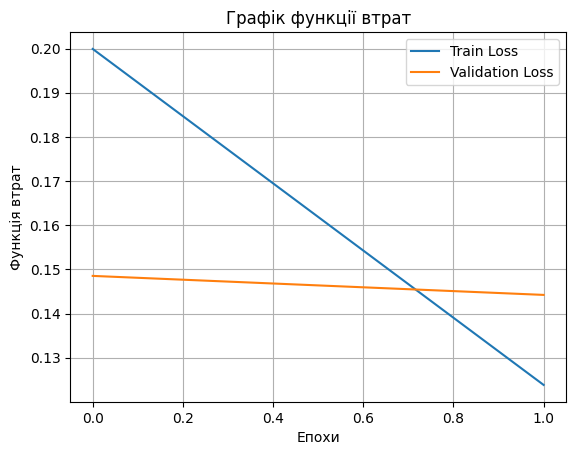

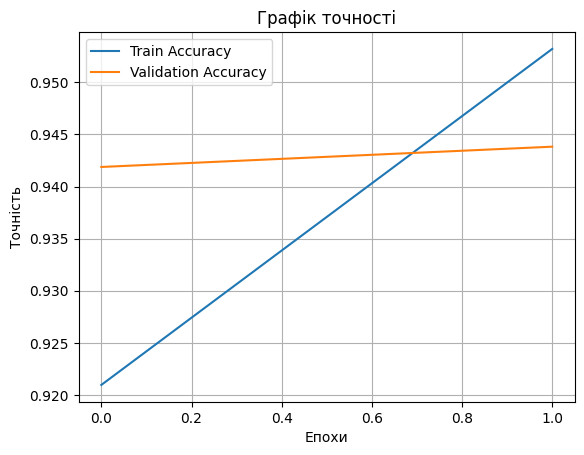

In [16]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Епохи')
plt.ylabel('Функція втрат')
plt.title('Графік функції втрат')
plt.legend()
plt.grid()
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Епохи')
plt.ylabel('Точність')
plt.title('Графік точності')
plt.legend()
plt.grid()
plt.show()

In [17]:
final_model = models.Sequential([encoder, lstm_model])
final_model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss=losses.BinaryCrossentropy(), metrics=["accuracy"])
final_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, None)           │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 1)              │    40,409,921 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,409,921 (154.15 MB)

 Trainable params: 40,409,921 (154.15 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
models.save_model(final_model, "./model.keras")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


In [20]:
final_model = models.load_model("./model.keras")

In [21]:
final_model.evaluate(test_ds)

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 47s 39ms/step - accuracy: 0.9444 - loss: 0.1414


[0.14060622453689575, 0.9452894926071167]